In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:9]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper']

In [14]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)
vocab_size

27

In [15]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [86]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embed, generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * (5/3)/((n_embed*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))

params = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12297


In [87]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr*p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
# print(loss.item())

      0/ 200000: 3.2820
  10000/ 200000: 2.4278
  20000/ 200000: 2.3188
  30000/ 200000: 2.1798
  40000/ 200000: 2.1292
  50000/ 200000: 2.0417
  60000/ 200000: 1.8676
  70000/ 200000: 2.2485
  80000/ 200000: 2.0067
  90000/ 200000: 2.1579
 100000/ 200000: 2.0240
 110000/ 200000: 2.0519
 120000/ 200000: 2.1314
 130000/ 200000: 2.0662
 140000/ 200000: 1.7506
 150000/ 200000: 2.1649
 160000/ 200000: 1.7519
 170000/ 200000: 1.9192
 180000/ 200000: 2.2092
 190000/ 200000: 1.8819


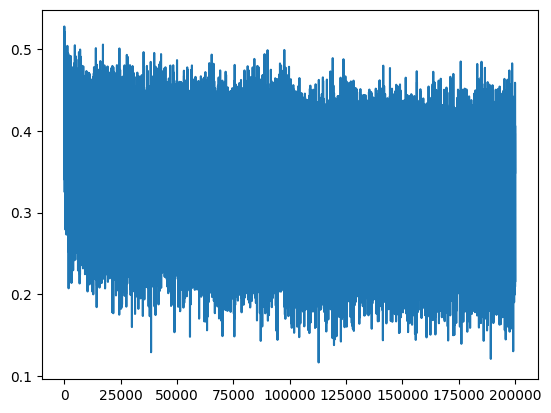

In [79]:
plt.plot(lossi)

In [85]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [80]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1) 
  hpreact = embcat @ W1 + b1
  hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.064404249191284
val 2.116751194000244


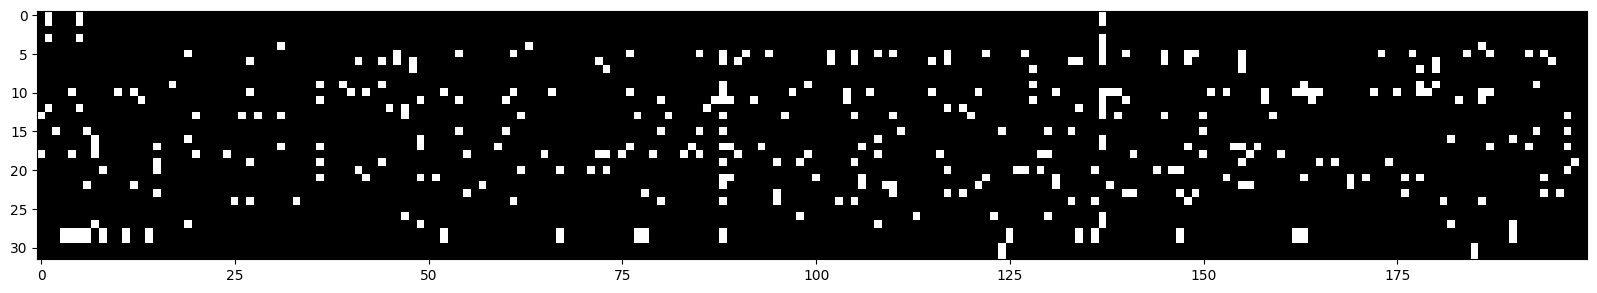

In [81]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [84]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

brithl.
sazzleermadhrisha.
suhrughkdrlegganghaddrlitzlyn.
penleighsonnthannkhlyn.
slussmi.
shdbvrgiagriell.
jutrvellhndsthungsubrgghd.
riyahlizeks.
kaylahsanvarihsandklynnsufizabrlventen.
subrks.
jaoszeprrdin.
quxsennyshptrvishtuthwskhmrenllingsortlev.
khwrllwilltarlizthlissiahsasitgf.
dvissivvi.
mell.
ketln.
vysxavravdusshffrrgyatth.
buddhi.
brishrishlquajadryanthoaggfidravifpirgson.
sthjynn.
